In [44]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [45]:
# Read the shoreline and bluff edges into a GeoDataFrame (to get get intersection points with transect)
gdf_be = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffEdge_1950to2020.zip')
gdf_sl = gpd.read_file('raw_datasets/gibbs/BarterIsland_Shoreline_1947to2020.zip')

# Read the shoreline and bluff edge change rate into a GeoDataFrame (to get transects)
gdf_be_cr = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffTransect_ChangeRates_1950to2020.zip')
# gdf_sl_cr = gpd.read_file('raw_datasets/gibbs/BarterIsland_ShoreTransect_ChangeRates_1947to2020.zip')  # not required, transects from bluff edge are used

# Read the bluff edge baseline into a GeoDataFrame (as a reference for the coastal retreat)
gdf_be_bl = gpd.read_file('raw_datasets/gibbs/BarterIsland_BluffEdgeBaseline.zip')


In [46]:
gdf_be.crs

<Projected CRS: EPSG:26907>
Name: NAD83 / UTM zone 7N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 144°W and 138°W - onshore and offshore. Canada - British Columbia; Yukon. United States (USA) - Alaska.
- bounds: (-144.0, 52.05, -137.99, 73.59)
Coordinate Operation:
- name: UTM zone 7N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
gdf_be_cr.geometry.values.unique()

<GeometryArray>
[<LINESTRING (400599.74 7783102.453, 400599.74 7783102.444, 400585.778 778280...>,
 <LINESTRING (400592.001 7783102.805, 400592.001 7783102.805, 400578.011 7782...>,
 <LINESTRING (400582.012 7783103.272, 400582.012 7783103.272, 400568.022 7782...>,
 <LINESTRING (400572.023 7783103.738, 400572.023 7783103.738, 400558.033 7782...>,
 <LINESTRING (400562.034 7783104.204, 400562.034 7783104.204, 400548.044 7782...>,
 <LINESTRING (400552.045 7783104.671, 400552.045 7783104.671, 400538.055 7782...>,
 <LINESTRING (400542.056 7783105.137, 400542.056 7783105.137, 400528.065 7782...>,
 <LINESTRING (400532.067 7783105.603, 400532.067 7783105.603, 400518.076 7782...>,
 <LINESTRING (400522.077 7783106.07, 400522.077 7783106.07, 400508.087 778280...>,
 <LINESTRING (400512.088 7783106.536, 400512.088 7783106.536, 400498.098 7782...>,
 ...
 <LINESTRING (397452.427 7783072.374, 397452.427 7783072.374, 397491.554 7782...>,
 <LINESTRING (397442.513 7783071.07, 397442.513 7783071.07, 397481

In [48]:
transect_ids = [100, 200, 300]

transects = [gdf_be_cr[gdf_be_cr.TransectID==id].to_crs(crs="4326") for id in transect_ids]

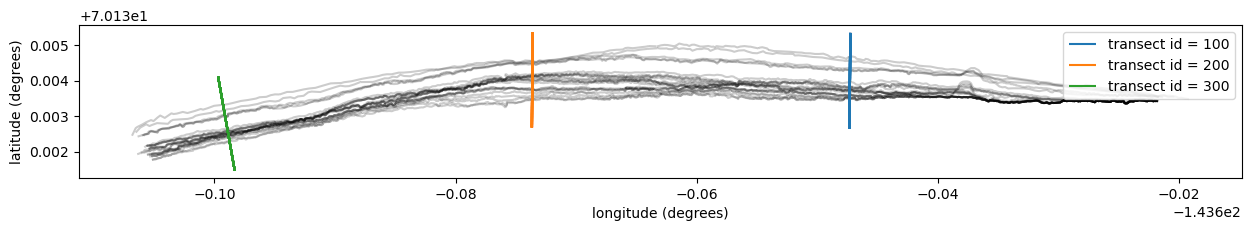

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))

gdf_be.to_crs(crs="4326").plot(ax=ax, color='black', alpha=0.2)
# gdf_sl.plot(ax=ax, color='blue', alpha=0.2)

i = 0

for id, transect in zip(transect_ids, transects):
    transect.plot(ax=ax, label=f'transect id = {id}', color=f'C{i}')
    i+=1

ax.set_xlabel("longitude (degrees)")
ax.set_ylabel("latitude (degrees)")

plt.legend()

In [50]:
def get_timeseries(gdf, gdf_changerate, gdf_baseline, transect_id):
    """
    Returns timeseries for bluff edge or shoreline depending on the given gdf.
    --------------
    gdf_changerate: 
        used to obtain the transect
    transect_id:
        transect id used to determine for which transect the timeseries is returned
    gdf:
        timeseries is determined from this gdf
    """

    # initialize dates, intersects and distance_from_ref(erence point) timeseries
    dates = []
    intersects = []
    distance_from_ref = []

    # get transect from changerate geodataframe
    transect = gdf_changerate[gdf_changerate.TransectID==transect_id].geometry.values[0]

    # get reference point from intersection baseline geodataframe
    ref = gdf_baseline.geometry.intersection(transect)
    # display(ref)

    # loop through all rows of geodataframe (each row represents a coastline, should end up with 25 points for all 25 measurement dates)
    for index, row in gdf.iterrows():

        intersect = row.geometry.intersection(transect)

        # check if there is an intersection (for some reason not each row gives an intersect)
        if not intersect.is_empty:
            
            # calculate distance from reference point to bluff edge
            d = intersect.distance(ref)

            # save date and intersect and distance
            dates.append(row.Date_)
            intersects.append(intersect)
            distance_from_ref.append(d)

    # create a geodataframe from the resulting dates, intersects, distances from reference. Also includes transect id and reference point
    result = gpd.GeoDataFrame(data={
        "date": dates,
        "distance_from_ref": distance_from_ref,
        "transect_id": np.ones(len(dates)) * transect_id,
        "ref_point": [ref]*len(dates)
        
    }, geometry=intersects, crs=gdf.crs)

    # finally we convert the dates to datetime for easy plotting
    result['date'] = pd.to_datetime(result['date'])

    return result

c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\bruij_kn\AppData\Local\mambaforge\envs\thesis\Lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)


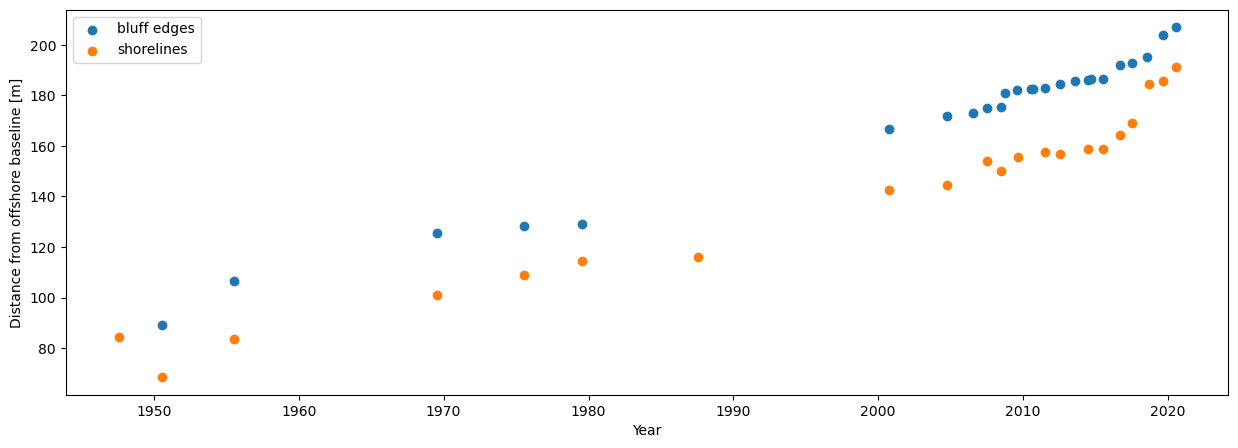

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))

bluff_edges = get_timeseries(gdf_be, gdf_be_cr, gdf_be_bl, 300).to_crs(crs="4326")
shore_lines = get_timeseries(gdf_sl, gdf_be_cr, gdf_be_bl, 300).to_crs(crs="4326")

ax.scatter(bluff_edges.date, bluff_edges.distance_from_ref, label='bluff edges')
ax.scatter(shore_lines.date, shore_lines.distance_from_ref, label='shorelines')

ax.set_xlabel("Year")
ax.set_ylabel("Distance from offshore baseline [m]")

plt.legend()

In [52]:
# rename date column to time column to be consistent
bluff_edges['time'] = bluff_edges['date']
shore_lines['time'] = shore_lines['date']

bluff_edges.drop(labels='date', inplace=True, axis=1)
shore_lines.drop(labels='date', inplace=True, axis=1)

# reorder to keep time in the first column
cols = bluff_edges.columns.tolist()
cols = cols[-1:] + cols[:-1]
bluff_edges = bluff_edges[cols]

cols = shore_lines.columns.tolist()
cols = cols[-1:] + cols[:-1]
shore_lines = shore_lines[cols]

In [53]:
path = "/ts_datasets/"

bluff_edges.to_csv(os.path.join("ts_datasets/", "bluff_edges.csv"))
shore_lines.to_csv(os.path.join("ts_datasets/", "shore_lines.csv"))